In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torchvision.utils import make_grid
from torchsummary import summary

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
transform=transforms.ToTensor()

In [4]:
train_data=datasets.MNIST(root="./",train=True,download=True,transform=transform)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
test_data=datasets.MNIST(root="./",train=False,download=True,transform=transform)

In [6]:
train_data


Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train
    StandardTransform
Transform: ToTensor()

In [7]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./
    Split: Test
    StandardTransform
Transform: ToTensor()

In [0]:
train_loader=DataLoader(train_data,batch_size=64,shuffle=True)
test_loader=DataLoader(test_data,batch_size=64,shuffle=False)


In [0]:
class ConvolutionalNetwork(nn.Module):


  def __init__(self):
    super().__init__()
    self.main= nn.Sequential(
        nn.Conv2d(1,32,3,1),
        nn.ReLU(),
        nn.Conv2d(32,64,3,1),
        nn.MaxPool2d(2),
        nn.Dropout2d(0.25),
    )
    self.fc = nn.Sequential(  
        nn.Linear(9216,128),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(128,10),
    )   
  
    pass
  def forward(self,X):
    x = self.main(X)
    x = self.fc(x.view(x.size(0),-1))
    return x

In [10]:
CNNcpu = ConvolutionalNetwork()
summary(CNNcpu,(1,28,28),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
              ReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 24, 24]          18,496
         MaxPool2d-4           [-1, 64, 12, 12]               0
         Dropout2d-5           [-1, 64, 12, 12]               0
            Linear-6                  [-1, 128]       1,179,776
              ReLU-7                  [-1, 128]               0
           Dropout-8                  [-1, 128]               0
            Linear-9                   [-1, 10]           1,290
Total params: 1,199,882
Trainable params: 1,199,882
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.75
Params size (MB): 4.58
Estimated Total Size (MB): 5.34
---------------------------------------

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNcpu.parameters(),lr=0.001)

In [0]:
for j,(X_train,y_train) in enumerate(train_loader):
    
  j+=1

  #TRAIN

  y_pred = CNNcpu(X_train)
  loss = criterion(y_pred,y_train)
  predicted = torch.max(y_pred.data,1)[1]
  print((predicted==y_train).sum())
  break

tensor(7)


In [0]:
import time
start_time = time.time()


#VARIABLES,TRACKERS


epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []


#FOR LOOP EPOCHS

for i in range(epochs):


  trn_corr = 0
  tst_corr = 0

  for j,(X_train,y_train) in enumerate(train_loader):
    
    j+=1

    #TRAIN

    y_pred = CNNcpu(X_train)
    loss = criterion(y_pred,y_train)

    predicted = torch.max(y_pred.data,1)[1]

    batch_corr = (predicted == y_train ).sum() 
    trn_corr+=batch_corr

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if j% 250== 0:
      print(f'epoch {i} : batch  {j} : loss {loss.item()}')


  train_losses.append(loss)
  train_correct.append(trn_corr) 

      
    #TEST
  with torch.no_grad():

    for i,(X_test,y_test) in enumerate(test_loader):
    
      i+=1

      y_tpred = CNNcpu(X_test)
      loss = criterion(y_tpred,y_test)

      predicted = torch.max(y_tpred.data,1)[1]

      batch_corr = (predicted == y_test ).sum() 
      tst_corr+=batch_corr


  test_losses.append(loss)
  test_correct.append(tst_corr) 



current_time = time.time()
print(f'the model took {(current_time-start_time)/60} minutes to train')

epoch 0 : batch  250 : loss 0.18497207760810852
epoch 0 : batch  500 : loss 0.08451282232999802
epoch 0 : batch  750 : loss 0.2572557330131531
epoch 1 : batch  250 : loss 0.08367303758859634
epoch 1 : batch  500 : loss 0.18041911721229553
epoch 1 : batch  750 : loss 0.1091872826218605
epoch 2 : batch  250 : loss 0.03247504681348801
epoch 2 : batch  500 : loss 0.024671005085110664
epoch 2 : batch  750 : loss 0.03961607441306114
epoch 3 : batch  250 : loss 0.08435685932636261
epoch 3 : batch  500 : loss 0.06583914160728455
epoch 3 : batch  750 : loss 0.11471857875585556
epoch 4 : batch  250 : loss 0.06194906681776047
epoch 4 : batch  500 : loss 0.013484097085893154
epoch 4 : batch  750 : loss 0.04395375773310661
the model took 7.417202687263488 minutes to train


In [0]:
CNNgpu = ConvolutionalNetwork().to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNgpu.parameters(),lr=0.001)

In [70]:
#FOR LOOP EPOCHS
import time
start_time = time.time()


#VARIABLES,TRACKERS


epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):


  trn_corr = 0
  tst_corr = 0

  for j,(X_train,y_train) in enumerate(train_loader):
    
    j+=1

    #TRAIN
    X_train = X_train.to('cuda')
    y_train = y_train.to('cuda')

    y_pred = CNNgpu(X_train)
    loss = criterion(y_pred,y_train)

    predicted = torch.max(y_pred.data,1)[1]

    batch_corr = (predicted == y_train ).sum() 
    trn_corr+=batch_corr

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if j% 250== 0:
      print(f'epoch {i} : batch  {j} : loss {loss.item()}')


  train_losses.append(loss)
  train_correct.append(trn_corr) 

      
    #TEST
  with torch.no_grad():

    for i,(X_test,y_test) in enumerate(test_loader):
    
      i+=1
      X_test = X_test.to('cuda')
      y_test = y_test.to('cuda')
      y_tpred = CNNgpu(X_test)
      loss = criterion(y_tpred,y_test)
      predicted = torch.max(y_tpred.data,1)[1]

      batch_corr = (predicted == y_test ).sum() 
      tst_corr+=batch_corr


  test_losses.append(loss)
  test_correct.append(tst_corr) 



current_time = time.time()
print(f'the model took {(current_time-start_time)/60} minutes to train')

epoch 0 : batch  250 : loss 0.0459829643368721
epoch 0 : batch  500 : loss 0.014791648834943771
epoch 0 : batch  750 : loss 0.03335406631231308
epoch 1 : batch  250 : loss 0.02988748997449875
epoch 1 : batch  500 : loss 0.11260310560464859
epoch 1 : batch  750 : loss 0.008187256753444672
epoch 2 : batch  250 : loss 0.07261008024215698
epoch 2 : batch  500 : loss 0.028909072279930115
epoch 2 : batch  750 : loss 0.0652664452791214
epoch 3 : batch  250 : loss 0.05853502079844475
epoch 3 : batch  500 : loss 0.014266863465309143
epoch 3 : batch  750 : loss 0.024557190015912056
epoch 4 : batch  250 : loss 0.004761874675750732
epoch 4 : batch  500 : loss 0.03870820254087448
epoch 4 : batch  750 : loss 0.003658868372440338
the model took 0.5527294397354126 minutes to train


Test accuracy Basic: 9815/10000 =  98.150%


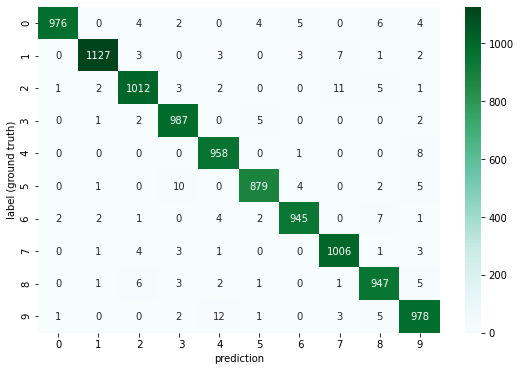

In [71]:
test_load_all = torch.utils.data.DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        X_test = X_test.to('cuda')
        y_test = y_test.to('cuda')
        y_val = CNNgpu(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
        
print(f'Test accuracy Basic: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

class_names = ['0', '1', ' 2', '  3', ' 4', ' 5', ' 6', '7', '8', '9']
arr = confusion_matrix(predicted.view(-1).cpu(), y_test.view(-1).cpu())
df_cm = pd.DataFrame(arr, class_names, class_names)
lis = df_cm.sum(axis=0)

plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

In [72]:
for i  in range(10):

  print(f'accuracy for class {i} is : {df_cm.iloc[i,i]*100/lis[i]}%')

accuracy for class 0 is : 99.59183673469387%
accuracy for class 1 is : 99.29515418502203%
accuracy for class 2 is : 98.06201550387597%
accuracy for class 3 is : 97.72277227722772%
accuracy for class 4 is : 97.55600814663951%
accuracy for class 5 is : 98.54260089686099%
accuracy for class 6 is : 98.64300626304802%
accuracy for class 7 is : 97.85992217898833%
accuracy for class 8 is : 97.22792607802874%
accuracy for class 9 is : 96.92765113974232%


In [0]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')

13
number is actually 9
number is predicted as 7
image is 


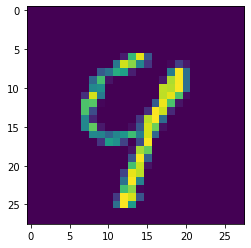

In [77]:
i = np.random.randint(0,len(misses),dtype=int)
print(i)
print(f'number is actually {y_test[misses[i].item()]}')
print(f'number is predicted as {predicted[misses[i]]}')
print(f'image is ')
plt.imshow(X_test[misses[i]].cpu().squeeze())

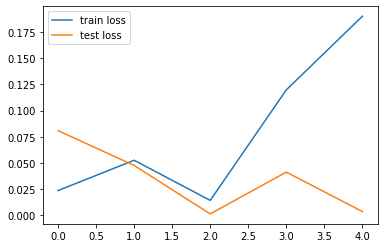

In [30]:
s plt.plot(train_losses,label = 'train loss')
 plt.plot(test_losses,label = 'test loss')
 plt.legend()
 plt.show()

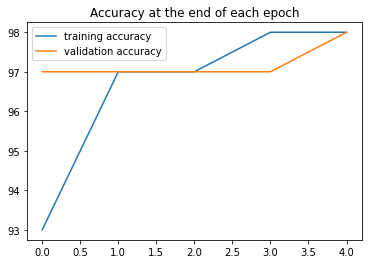

In [0]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();